### Importing Libraries

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Input, ReLU, add, BatchNormalization, DepthwiseConv2D, GlobalAveragePooling2D, Dense

### Constants

In [3]:
batch_size = 32
num_classes = 124
tf.random.set_seed(42)
img_height, img_width = 128, 128
data_dir = os.path.join(os.getcwd(), "../5-Gait-Energy-Images")

### Training Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    rescale=1.0 / 255,
    rotation_range=20,
    fill_mode="nearest",
    horizontal_flip=True,
    zoom_range=[0.8, 1.2],
    width_shift_range=0.2,
    validation_split=0.15,
    height_shift_range=0.2,
    channel_shift_range=10,
    brightness_range=[0.8, 1.2],
)

### Testing Data Augmentation

In [5]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and split data into training and testing sets

In [6]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=True,
    subset="training",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=False,
    subset="validation",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

Found 11587 images belonging to 124 classes.
Found 1974 images belonging to 124 classes.


### MobileNetV2 Model

In [7]:
def expansion_block(x, t, filters, block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t * filters
    x = Conv2D(total_filters, 1, padding='same',
               use_bias=False, name=prefix + 'expand')(x)
    x = BatchNormalization(name=prefix + 'expand_bn')(x)
    x = ReLU(6, name=prefix + 'expand_relu')(x)
    return x


def depthwise_block(x, stride, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3, strides=(stride, stride), padding='same',
                        use_bias=False, name=prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix + 'dw_bn')(x)
    x = ReLU(6, name=prefix + 'dw_relu')(x)
    return x


def projection_block(x, out_channels, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels, kernel_size=1, padding='same',
               use_bias=False, name=prefix + 'compress')(x)
    x = BatchNormalization(name=prefix + 'compress_bn')(x)
    return x


def Bottleneck(x, t, filters, out_channels, stride, block_id):
    y = expansion_block(x, t, filters, block_id)
    y = depthwise_block(y, stride, block_id)
    y = projection_block(y, out_channels, block_id)
    if y.shape[-1] == x.shape[-1]:
        y = add([x, y])
    return y


def MobileNetV2(input_shape, n_classes):
    input = Input(input_shape)
    x = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False)(input)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name='conv1_relu')(x)
    x = projection_block(x, out_channels=16, block_id=1)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=24, stride=2, block_id=2)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=24, stride=1, block_id=3)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=32, stride=2, block_id=4)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=32, stride=1, block_id=5)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=32, stride=1, block_id=6)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=64, stride=2, block_id=7)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=64, stride=1, block_id=8)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=64, stride=1, block_id=9)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=64, stride=1, block_id=10)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=96, stride=1, block_id=11)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=96, stride=1, block_id=12)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=96, stride=1, block_id=13)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=160, stride=2, block_id=14)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=160, stride=1, block_id=15)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=160, stride=1, block_id=16)
    x = Bottleneck(
        x, t=6, filters=x.shape[-1], out_channels=320, stride=1, block_id=17)
    x = Conv2D(filters=1280, kernel_size=1, padding='same',
               use_bias=False, name='last_conv')(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6, name='last_relu')(x)
    x = GlobalAveragePooling2D(name='global_average_pool')(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(input, output)
    return model

### Create the model

In [8]:
model = MobileNetV2(input_shape=(128, 128, 1), n_classes=num_classes)

2024-04-18 13:24:45.480741: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Define Top k Accuracy Function

In [9]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

### Compile the model

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['acc', top_5_accuracy])

### Define the Callbacks

In [11]:
checkpoint = ModelCheckpoint(
    "best_model.h5", monitor='val_acc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_acc', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', factor=0.1, patience=5, min_lr=1e-7)

### Train the model

In [12]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=500,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    use_multiprocessing=True)

Epoch 1/500
363/363 [==============================] - ETA: 0s - loss: 4.6647 - acc: 0.0271 - top_5_accuracy: 0.1128

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


363/363 [==============================] - 111s 277ms/step - loss: 4.6647 - acc: 0.0271 - top_5_accuracy: 0.1128 - val_loss: 5.4435 - val_acc: 0.0081 - val_top_5_accuracy: 0.0405 - lr: 0.0010
Epoch 2/500
363/363 [==============================] - 80s 218ms/step - loss: 4.0703 - acc: 0.0658 - top_5_accuracy: 0.2357 - val_loss: 4.5418 - val_acc: 0.0714 - val_top_5_accuracy: 0.2052 - lr: 0.0010
Epoch 3/500
363/363 [==============================] - 84s 228ms/step - loss: 3.7088 - acc: 0.1085 - top_5_accuracy: 0.3259 - val_loss: 6.5295 - val_acc: 0.0669 - val_top_5_accuracy: 0.1479 - lr: 0.0010
Epoch 4/500
363/363 [==============================] - 80s 216ms/step - loss: 3.4072 - acc: 0.1563 - top_5_accuracy: 0.4169 - val_loss: 8.1494 - val_acc: 0.0502 - val_top_5_accuracy: 0.1530 - lr: 0.0010
Epoch 5/500
363/363 [==============================] - 79s 214ms/step - loss: 3.1420 - acc: 0.1978 - top_5_accuracy: 0.4870 - val_loss: 5.9586 - val_acc: 0.0598 - val_top_5_accuracy: 0.2082 - lr: 0.0

### Evaluate model on training set

In [13]:
train_loss, train_accuracy, top5train = model.evaluate(train_generator)
print(f"Training Loss: {round(train_loss, 2)}")
print(f"Training Accuracy: {round(train_accuracy, 2)}")
print(f"Training Top 5 Accuracy: {round(top5train, 2)}")

363/363 [==============================] - 37s 102ms/step - loss: 0.0530 - acc: 0.9867 - top_5_accuracy: 0.9997
Training Loss: 0.05
Training Accuracy: 0.99
Training Top 5 Accuracy: 1.0


### Evaluate model on testing set

In [14]:
test_loss, test_accuracy, top5test = model.evaluate(test_generator)
print(f"Testing Loss: {round(test_loss, 2)}")
print(f"Testing Accuracy: {round(test_accuracy, 2)}")
print(f"Testing Top 5 Accuracy: {round(top5test, 2)}")

62/62 [==============================] - 4s 57ms/step - loss: 0.4948 - acc: 0.8759 - top_5_accuracy: 0.9777
Testing Loss: 0.49
Testing Accuracy: 0.88
Testing Top 5 Accuracy: 0.98


### Save the model

In [15]:
model.save('../10-Trained-Models/MobileNetV2.h5')

### Model Summary

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           288       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)           128       ['conv2d[0][0]']              
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['conv1_bn[0][0]']        

### Plot Training & Validation Accuracy

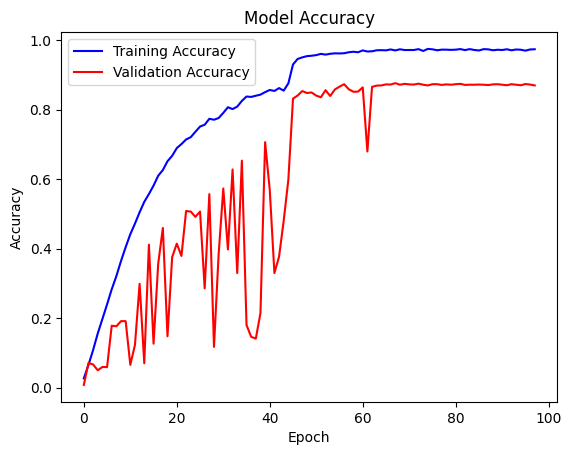

In [17]:
plt.plot(history.history['acc'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_acc'],
         color='red', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

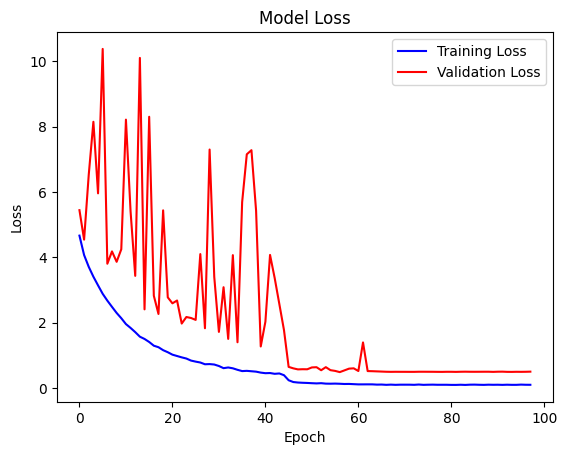

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot Training and Testing Top 5 Accuracy

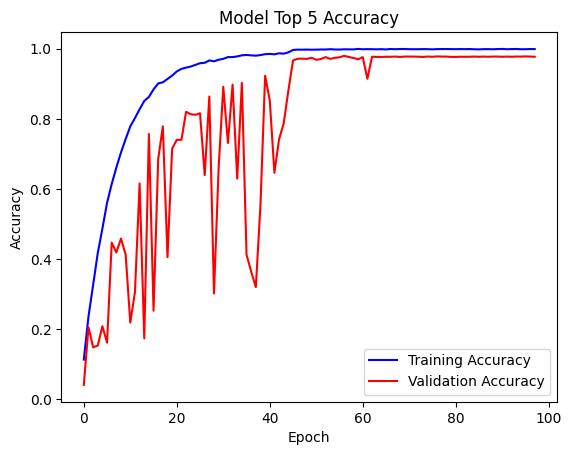

In [19]:
plt.plot(history.history['top_5_accuracy'],
         color='blue', label='Training Accuracy')
plt.plot(history.history['val_top_5_accuracy'],
         color='red', label='Validation Accuracy')
plt.title('Model Top 5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()